# Watch Movement Classification
<hr>

Date : 22/02/2023  
Auteur : Gaël Penessot  
email : gaelpenessot@data-decision.io  
  
This notebook is a POC for watch movement classification based on CNN (ResNet152).

## 1. Load and preprocess images

### 1.1 Setup

In [1]:
from fastcore.all import *
from fastai.vision.all import *
from fastai.vision.widgets import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Librariries for Pytorch Mobile conversion
import torch
import torchvision
from torch.utils.mobile_optimizer import optimize_for_mobile

import warnings
warnings.filterwarnings("ignore")

C:\Users\gaelp\anaconda3\envs\projet\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] La procédure spécifiée est introuvable
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Check if GPU is available
if torch.cuda.is_available():
    print('> CUDNN VERSION:', torch.backends.cudnn.version())
    print('> Number CUDA Devices:', torch.cuda.device_count())
    print('> CUDA Device Name:',torch.cuda.get_device_name(0))
    print('> CUDA Device Total Memory [GB]:',np.round(torch.cuda.get_device_properties(0).total_memory/1e9, 2))

> CUDNN VERSION: 8302
> Number CUDA Devices: 1
> CUDA Device Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
> CUDA Device Total Memory [GB]: 4.29


### 1.2 Load data

Let's load these images off disk using the `DataBlock` utility.

In [3]:
path = Path('movement_database')

watches = DataBlock(
                blocks=(ImageBlock, CategoryBlock), 
                get_items=get_image_files, 
                splitter=RandomSplitter(valid_pct=0.2, seed=42),
                get_y=parent_label)

watches=watches.new(item_tfms=Resize(256, 
                                     method='squish'),
                    batch_tfms=aug_transforms(do_flip=False, 
                                              max_rotate=45.))

dls=watches.dataloaders(path, bs=8) #batch size set to 8 to prevent GPU memory allocation error

TypeError: 'NoneType' object is not iterable

## 2. Visualize the data

Here are the first 6 images from the training dataset.

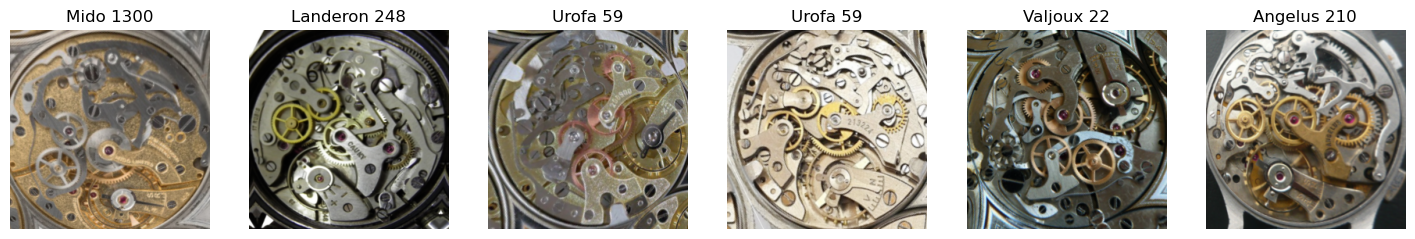

In [24]:
dls.show_batch(max_n=6, nrows=1)

In [6]:
learn = vision_learner(dls, resnet152, metrics=accuracy)
learn.fine_tune(30)

In [7]:
learn.save('model_20022023')

Path('models/model_20022023.pth')

In [ ]:
#model = load_learner('model_1002023.pkl')

## Model interpretation

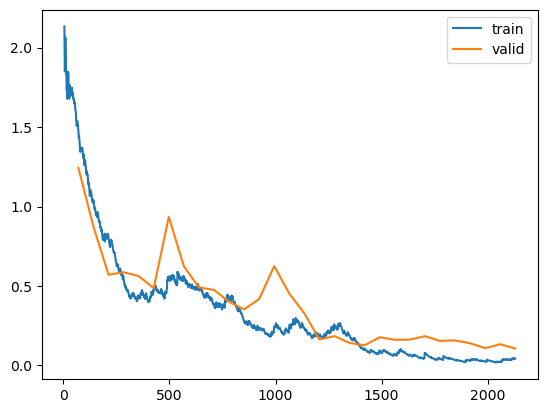

In [8]:
learn.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

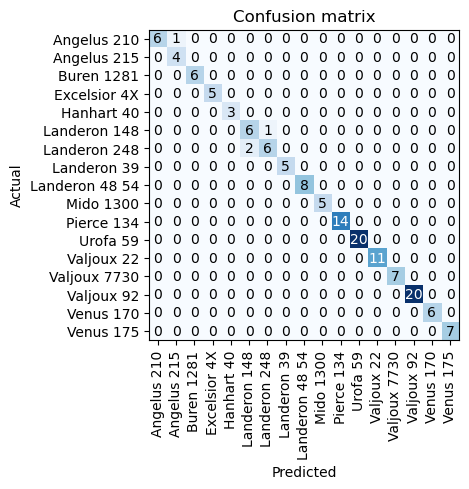

In [ ]:
interp.plot_confusion_matrix()

The Landeron 148 and 248 are really close visually. 

| Landeron 148 | Landeron 248 |
|:------------:|:------------:|
|![Landeron 148](./img/schema_landeron_148.jpg) | ![Landeron 248](./img/schema_landeron_248.jpg) |

If we plot top losses, we can see that the main issue are the wrong predictions about Landeron 148/248 movement.

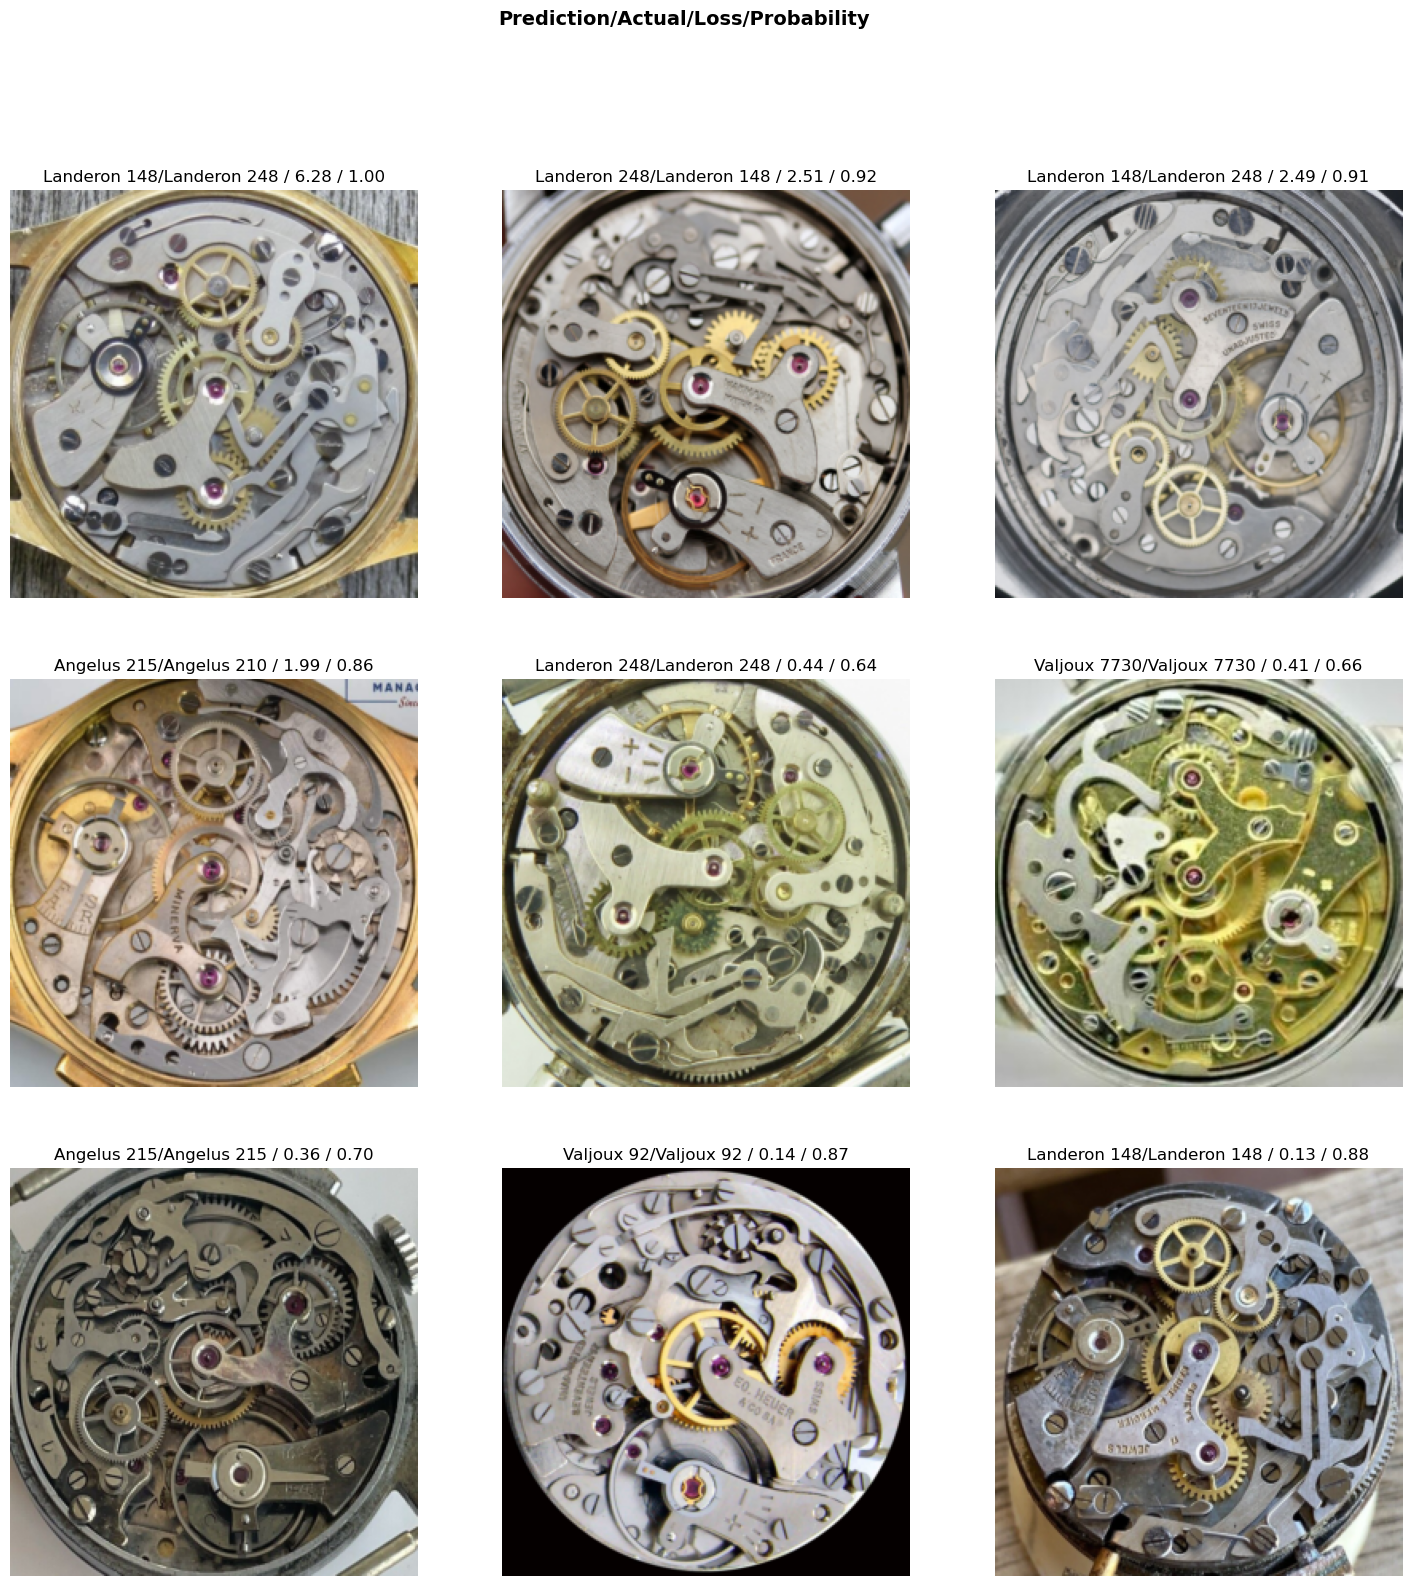

In [ ]:
interp.plot_top_losses(9, nrows=3, figsize=(18,18))

## Data set cleaning (if necessary)

In [10]:
cleaner = ImageClassifierCleaner(learn)

In [11]:
cleaner

## Export model to Pytorch Mobile

In [1]:
torch.save(learner.model, 'model_24022023.pkl')

NameError: name 'torch' is not defined

In [ ]:
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model.forward, example)
traced_script_module_optimized = optimize_for_mobile(traced_script_module)
traced_script_module_optimized._save_for_lite_interpreter("model.ptl")

# Test

Let's test on a picture the model.

In [13]:
mov,_,probs = learn.predict(PILImage.create('test_image.jpg'))
im = Image.open('test_image.jpg')

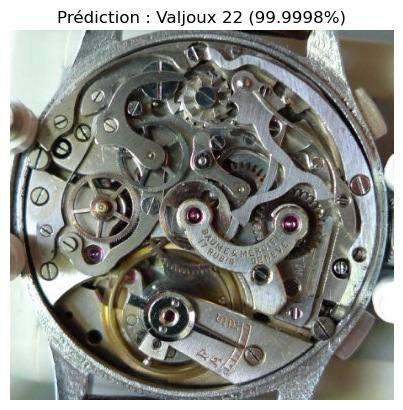

In [14]:
plt.imshow(im)
plt.title('Prédiction : {} ({:.4f}%)'.format(mov, max(probs)*100))
plt.axis('off')
plt.show()